# 05. Prediction Pipelines
Fitting, tuning and packing prediction pipelines

In [2]:
# change wd to repo home
import os
if os.getcwd().split('\\')[-1] == 'notebooks':
    os.chdir('..')

In [3]:
from modules.fm_functions import *

Load data

In [4]:
import pandas as pd
player_data_2022 = pd.read_csv('./data/FM_fbref_combined_data_2022.csv', index_col='_Player_').iloc[:, 1:].dropna(axis=0)
player_data_2023 = pd.read_csv('./data/FM_fbref_combined_data_2023.csv', index_col='_Player_').iloc[:, 1:].dropna(axis=0)

team_data_2022 = pd.read_csv('./data/2022_FBRef_teams.csv', index_col=0)
team_data_2023 = pd.read_csv('./data/2023_FBRef_teams.csv', index_col=0)
team_data_2022.columns = [f'team_{col}' for col in team_data_2022.columns]
team_data_2023.columns = [f'team_{col}' for col in team_data_2023.columns]

player_team_2022 = pd.read_csv('./data/2022_FBRef_meandiff.csv', index_col=1).loc[:, ['_Squad_']]
player_team_2023 = pd.read_csv('./data/2023_FBRef_meandiff.csv', index_col=1).loc[:, ['_Squad_']]

In [5]:
combined_data_2022 = pd.merge(player_data_2022.join(player_team_2022).reset_index(), team_data_2022, left_on='_Squad_', right_on=team_data_2022.index)
combined_data_2023 = pd.merge(player_data_2023.join(player_team_2023).reset_index(), team_data_2023, left_on='_Squad_', right_on=team_data_2023.index)

combined_data_2022.index = combined_data_2022['_Player_']
combined_data_2023.index = combined_data_2023['_Player_']

combined_data_2022.drop_duplicates(inplace=True)
combined_data_2023.drop_duplicates(inplace=True)

combined_data_2022.drop(['_Player_', '_Squad_'], axis=1, inplace=True)
combined_data_2023.drop(['_Player_', '_Squad_'], axis=1, inplace=True)


In [6]:
team_columns = team_data_2022.columns.to_list()

In [7]:
feature_columns = all_stats_columns + team_columns

X = combined_data_2022[feature_columns].values
y = combined_data_2022[FM_columns].values

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, combined_data_2022.index, test_size=0.33, random_state=42)

In [65]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

In [66]:
X[:, :len(all_stats_columns)]

array([[-0.01724138, -0.33053691, -0.36666667, ..., -0.25490196,
        -0.10738255, -0.10157618],
       [-0.48522167, -0.64932886, -0.76969697, ..., -1.        ,
         0.11577181, -0.33450088],
       [-0.43842365, -0.36241611, -0.19393939, ..., -0.62745098,
        -0.48993289, -0.70052539],
       ...,
       [ 0.83333333,  0.69811321,  0.48101266, ...,  0.5       ,
        -0.2173913 ,  0.04887218],
       [ 0.125     , -0.01509434, -0.03164557, ..., -1.        ,
         0.81422925,  0.2518797 ],
       [ 0.08333333, -0.01509434, -0.14556962, ..., -0.25      ,
        -0.2173913 ,  0.35338346]])

<Axes: >

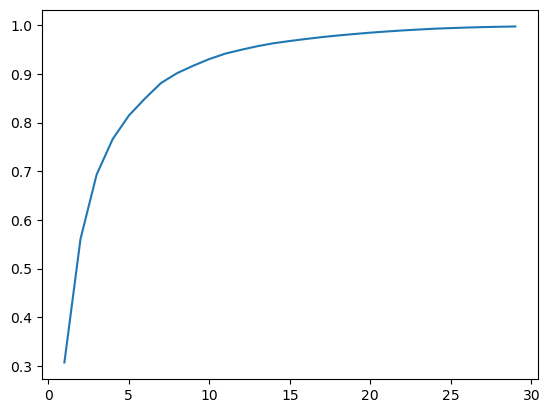

In [67]:
pca_results = {}

for n_components in range(1, 30):
    pca = PCA(n_components=n_components)
    pca.fit(X[:, :len(all_stats_columns)])
    pca_results[n_components] = pca.explained_variance_ratio_.sum()

sns.lineplot(pca_results)

<Axes: >

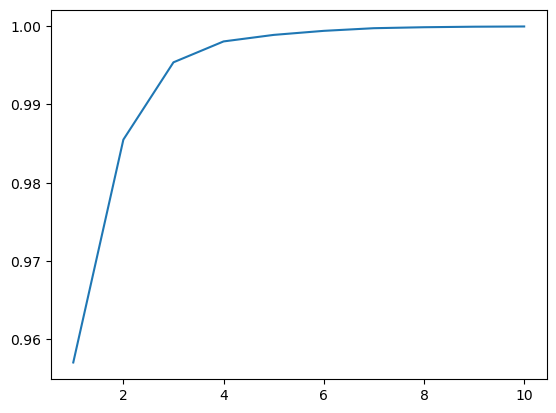

In [68]:
pca_results = {}

for n_components in range(1, 11):
    pca = PCA(n_components=n_components)
    pca.fit(X[:, len(all_stats_columns):])
    pca_results[n_components] = pca.explained_variance_ratio_.sum()

sns.lineplot(pca_results)

In [69]:
preprocessing_player = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA())
])

preprocessing_team = Pipeline([
    ('scaling', StandardScaler()),
    ('pca', PCA(n_components=3))
])

preprocessing = ColumnTransformer([
    ('preprocess_player', preprocessing_player, list(range(len(all_stats_columns)))),
    ('preprocess_team', preprocessing_team, list(range(len(all_stats_columns), len(feature_columns))))
])

pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

In [70]:
param_grid = {
    'preprocessing__preprocess_player__pca__n_components' : [4,7,10,15],
    'preprocessing__preprocess_team__pca__n_components' : [2,3,4],
    # 'mlp__hidden_layer_sizes' : [(50,)],
    # 'mlp__hidden_layer_sizes' : [(50,), (100,)],
    'mlp__hidden_layer_sizes' : [(50,), (100,), (50, 50), (25, 50, 25), (200)],
    # 'mlp__activation' : ['tanh']
    'mlp__activation' : ['tanh', 'relu']
}

In [71]:
# grid_search = RandomizedSearchCV(pipeline, param_grid, cv=5)
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alibe\minic

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('preprocess_player',
                                                                         Pipeline(steps=[('scaling',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          23,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          27,
                                                                          28,
                                                                          29, ...]),
                                                                        ('preprocess_team',
                                                                         Pipeline(steps=[('scaling',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=...
                                                                          54,
                                                                          55,
                                                                          56,
                                                                          57,
                                                                          58,
                                                                          59,
                                                                          60,
                                                                          61,
                                                                          62,
                                                                          63,
                                                                          64,
                                                                          65,
          

In [72]:
print('Best parameters found: ', grid_search.best_params_)
print('Best cross-validation score: ', grid_search.best_score_)

Best parameters found:  {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (50,), 'preprocessing__preprocess_player__pca__n_components': 7, 'preprocessing__preprocess_team__pca__n_components': 3}
Best cross-validation score:  0.23913040720469092


In [74]:
model = grid_search.best_estimator_
print(f'Train R^2 : {model.score(X_train, y_train)}')
print(f'Test R^2 : {model.score(X_test, y_test)}')
print(f'Train MSE : {mean_squared_error(y_train, model.predict(X_train))}')
print(f'Test MSE : {mean_squared_error(y_test, model.predict(X_test))}')

Train R^2 : 0.29490178789108823
Test R^2 : 0.2668041699718109
Train MSE : 4.411021895019068
Test MSE : 4.597752479495111


In [22]:
model.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('preprocess_player',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24, 25, 26, 27, 28, 29, ...]),
                                                 ('preprocess_team',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=3))]),
                                                  [41, 42, 43, 44, 45, 46, 47,
                                                   48, 49, 50, 51, 52, 53, 54,
                                                   55, 56, 57, 58, 59, 60, 61,
                                                   62, 63, 64, 65, 66, 67, 68,
                                                   69, 70, ...])])),
                ('mlp',
                 MLPRegressor(activation='tanh', max_iter=1000,
                              random_state=42))])

In [76]:
import pickle

with open('FM_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [44]:
find_most_similar_strings('miranchuk', combined_data_2022.index, n=3)

['Aleksei Miranchuk', 'Matteo Bianchetti', 'Jadon Sancho']

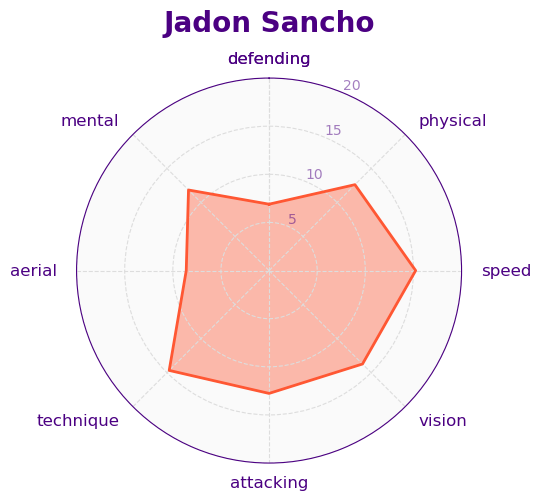

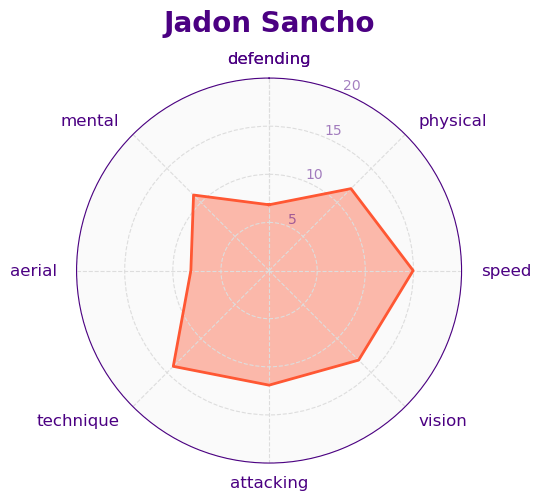

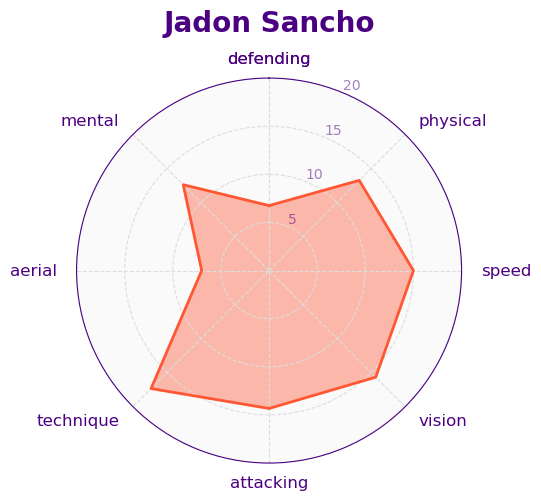

In [75]:
test_name = 'Jadon Sancho'

predictions_2022 = model.predict(combined_data_2022.loc[[test_name], feature_columns].values)
predictions_2022 = pd.Series(predictions_2022[0], index=FM_columns)
predictions_2022['_Player_'] = test_name
predictions_2022_graph = calculate_skill_nodes(predictions_2022)
plot_fm_radar(predictions_2022_graph, gk=False)

predictions_2023 = model.predict(combined_data_2023.loc[[test_name], feature_columns].values)
predictions_2023 = pd.Series(predictions_2023[0], index=FM_columns)
predictions_2023['_Player_'] = test_name
predictions_2023_graph = calculate_skill_nodes(predictions_2023)
plot_fm_radar(predictions_2023_graph, gk=False)

real = combined_data_2022.loc[[test_name], FM_columns].iloc[0]
real['_Player_'] = test_name
real_graph = calculate_skill_nodes(real)
real_graph['name'] = test_name
plot_fm_radar(real_graph, gk=False)

In [25]:
all_predictions_2022 = model.predict(combined_data_2022[feature_columns])

all_predictions_2022 = pd.DataFrame(all_predictions_2022, index=combined_data_2022.index,
                                    columns=FM_columns)

c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
c:\Users\alibe\miniconda3\envs\fbref\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [27]:
(abs(all_predictions_2022 - combined_data_2022[FM_columns])).mean(axis=1).sort_values()

_Player_
Martin Satriano       0.669537
Nedim Bajrami         0.740946
Anthony Lozano        0.762863
Clément Lenglet       0.780141
Morgan Sanson         0.785711
                        ...   
Mohamed Camara        4.875534
Leandro Paredes       4.896173
Luis Alberto          4.955976
Alejandro Garnacho    5.473716
Alejandro Balde       6.042443
Length: 1898, dtype: float64

<Axes: >

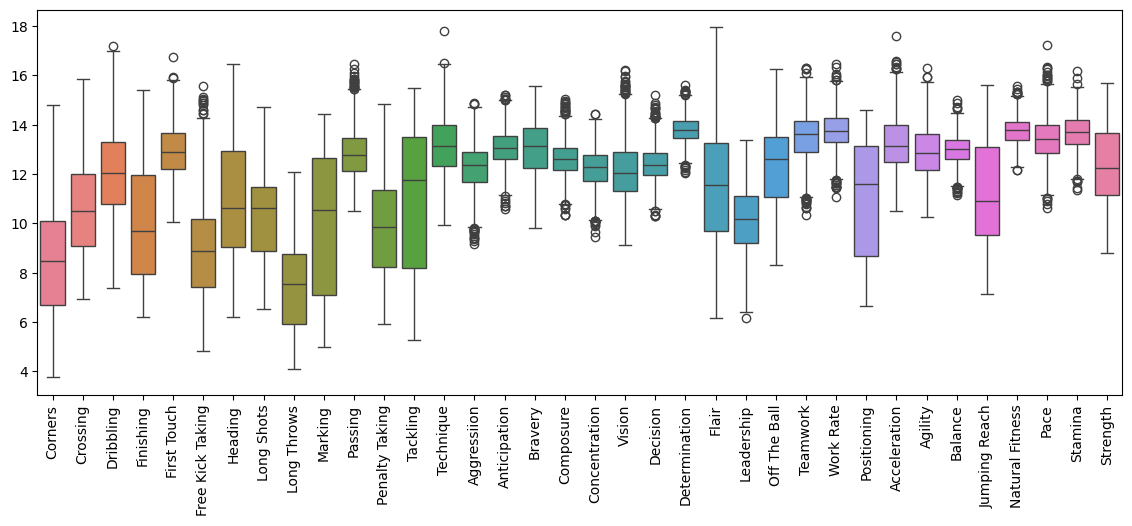

In [61]:
fig, ax = plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.boxplot(all_predictions_2022)

<Axes: >

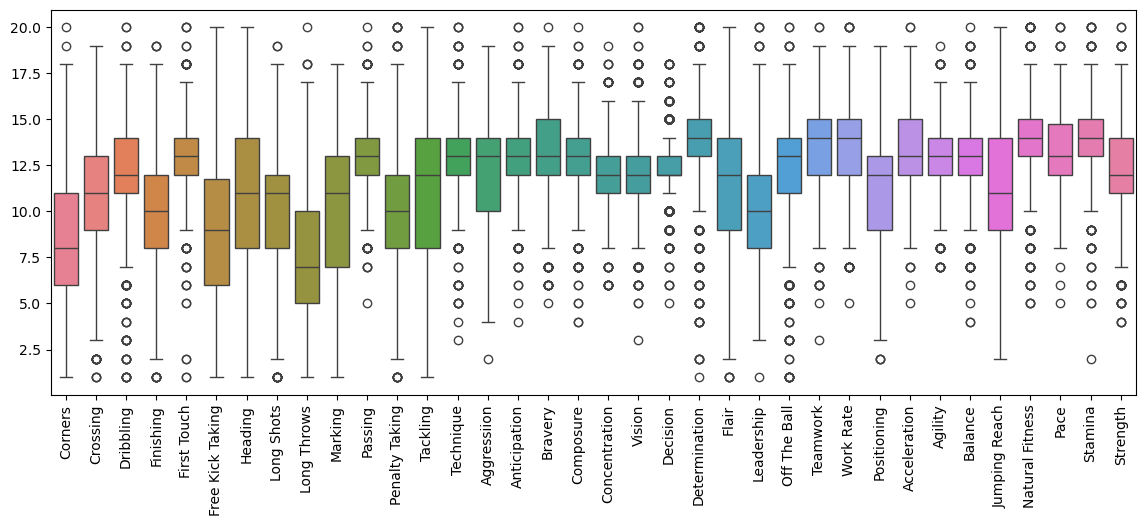

In [62]:
fig, ax = plt.subplots(figsize=(14,5))
plt.xticks(rotation=90)
sns.boxplot(combined_data_2022[FM_columns])